In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Imports

In [2]:
import numpy as np

from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

Using TensorFlow backend.


### Plot func

In [31]:
def plot_model(model_details):

    # Create sub-plots
    fig, axs = subplots(1, 2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    
def plot_images(images, labels_true, class_names, labels_pred=None):

    # Create a figure with sub-plots
    fig, axes = plt.subplots(3, 3, figsize = (8,8))

    # Adjust the vertical spacing
    if labels_pred is None:
        hspace = 0.2
    else:
        hspace = 0.5
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Fix crash when less than 9 images
        if i < len(images):
            # Plot the image
            ax.imshow(images[i], interpolation='spline16')
            
            # Name of the true class
            labels_true_name = class_names[labels_true[i]]

            # Show true and predicted classes
            if labels_pred is None:
                xlabel = "True: "+labels_true_name
            else:
                # Name of the predicted class
                labels_pred_name = class_names[labels_pred[i]]

                xlabel = "True: "+labels_true_name+"\nPredicted: "+ labels_pred_name

            # Show the class on the x-axis
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    

### Load data

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
IMAGE_SIZE, CHANNELS = x_train.shape[2:]
print(IMAGE_SIZE, CHANNELS)
print(np.unique(y_train))
num_classes = len(np.unique(y_train))

32 3
[0 1 2 3 4 5 6 7 8 9]


In [5]:
print("Training set size:\t",len(y_train))
print("Testing set size:\t",len(y_test))

Training set size:	 50000
Testing set size:	 10000


In [26]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Define the CNN model

In [6]:
def cnn_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)))    
    model.add(Conv2D(32, (3, 3), activation='relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    
    return model

In [7]:
model = cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [8]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(lr=1.0e-4), # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy']) # Metrics to be evaluated by the model

### Train model on the training data

Save the model after every epoch

In [9]:
checkpoint = ModelCheckpoint('best_model_simple.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 

Fit the model on the data provided

In [10]:
model_details = model.fit(x_train, y_train,
             batch_size = 128, # number of samples per gradient update
                    epochs = 100, # number of iterations
                    validation_data= (x_test, y_test),
                    callbacks=[checkpoint],
                    verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 179us/step - loss: 5.9793 - acc: 0.1790 - val_loss: 1.8927 - val_acc: 0.3586
Epoch 2/100
50000/50000 [==============================] - 6s 126us/step - loss: 1.8580 - acc: 0.3215 - val_loss: 1.6072 - val_acc: 0.4251
Epoch 3/100
50000/50000 [==============================] - 6s 127us/step - loss: 1.6529 - acc: 0.3952 - val_loss: 1.4671 - val_acc: 0.4768
Epoch 4/100
50000/50000 [==============================] - 6s 128us/step - loss: 1.5251 - acc: 0.4493 - val_loss: 1.3953 - val_acc: 0.5047
Epoch 5/100
50000/50000 [==============================] - 6s 127us/step - loss: 1.4378 - acc: 0.4805 - val_loss: 1.2845 - val_acc: 0.5471
Epoch 6/100
50000/50000 [==============================] - 6s 128us/step - loss: 1.3624 - acc: 0.5136 - val_loss: 1.2604 - val_acc: 0.5544
Epoch 7/100
50000/50000 [==============================] - 6s 128us/step - loss: 1.2954 - acc: 0.5386 - val_loss: 1.

### Evaluate the model

In [11]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.53%


### Model accuracy and loss plots

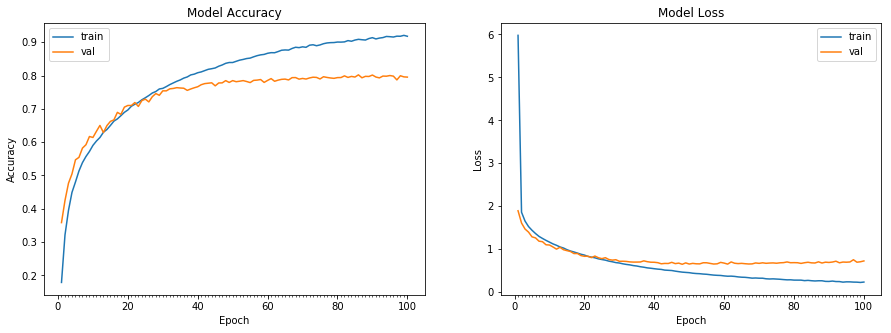

In [33]:
plot_model(model_details)

### Predictions

Predict class for test set images

In [14]:
class_pred = model.predict(x_test, batch_size=32)
print(class_pred[0])

[  2.60031607e-06   1.06273009e-03   8.34538223e-05   6.57735884e-01
   8.52652349e-08   4.46010195e-02   2.59667039e-01   3.48923606e-07
   3.68197374e-02   2.71431691e-05]


Get the index of the largest element in each vector

In [15]:
labels_pred = np.argmax(class_pred,axis=1)
print(labels_pred)

[3 8 8 ..., 5 1 7]


Check which labels have been predicted correctly

In [22]:
correct = (labels_pred == y_test[:, 0]).astype('int32')
print(correct)
print("Number of correct predictions: %d" % sum(correct))

[1 1 1 ..., 1 1 1]
Number of correct predictions: 7953


Calculate accuracy using manual calculation

In [23]:
num_images = len(correct)
print("Accuracy: %.2f%%" % ((sum(correct)*100)/num_images))

Accuracy: 79.53%


### Show some mis-classifications

Get the incorrectly classified images

In [29]:
incorrect = (correct == 0)

# Images of the test-set that have been incorrectly classified.
images_error = x_test[incorrect]

# Get predicted classes for those images
labels_error = labels_pred[incorrect]

# Get true classes for those images
labels_true = y_test[:, 0][incorrect]

Plot the first 9 mis-classified images

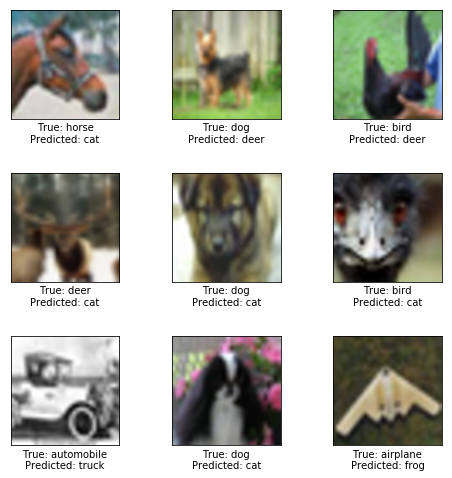

In [32]:
plot_images(images=images_error[0:9],
            labels_true=labels_true[0:9],
            class_names=class_names,
            labels_pred=labels_error[0:9])